In [71]:
import at
import numpy as np
from at import Lattice
from pySC.utils.at_wrapper import atloco
from pySC.core.simulated_commissioning import SimulatedCommissioning
from pySC.correction.orbit_trajectory import SCfeedbackFirstTurn, SCfeedbackStitch, SCfeedbackRun, SCfeedbackBalance, \
    SCpseudoBBA
from pySC.core.beam import bpm_reading, beam_transmission
from pySC.core.constants import *
from pySC.correction.tune import tune_scan
from pySC.lattice_properties.response_model import SCgetModelRM, SCgetModelDispersion
from pySC.lattice_properties.response_measurement import *
from pySC.utils.sc_tools import SCgetOrds, SCgetPinv
from pySC.correction.loco_wrapper import (loco_model, loco_fit_parameters, apply_lattice_correction, loco_measurement,
                                          loco_bpm_structure, loco_cm_structure)
from pySC.plotting.plot_phase_space import plot_phase_space
from pySC.plotting.plot_support import plot_support
from pySC.plotting.plot_lattice import plot_lattice
from pySC.core.lattice_setting import set_magnet_setpoints, switch_cavity_and_radiation, set_cm_setpoints
from pySC.correction.rf import correct_rf_phase, correct_rf_frequency, phase_and_energy_error
from pySC.utils import logging_tools
#from pySC.correction.loco_modules import *
from pySC.correction.orbit_trajectory import SCfeedbackRun

from at_modules_loco import *

LOGGER = logging_tools.get_logger(__name__)


def create_at_lattice() -> Lattice:
    def _marker(name):
        return at.Marker(name, PassMethod='IdentityPass')
    new_ring = at.load_mat('p3_v24')
    new_ring.radiation_off()
    new_ring.energy = 6e9
    #new_ring.set_cavity(Voltage=1.66 ,Frequency=400786627.09839934)
    new_ring.enable_6d()
    at.set_cavity_phase(new_ring)
    at.set_rf_frequency(new_ring)
    new_ring.tapering(niter=3, quadrupole=True, sextupole=True)
    return new_ring


if __name__ == "__main__":
    ring = at.Lattice(create_at_lattice())
    nominal_tune = get_tune(ring, get_integer=True)
    nominal_crom = get_chrom(ring)
    LOGGER.info(f"{len(ring)=}")
    SC = SimulatedCommissioning(ring)

    ords = SCgetOrds(SC.RING, 'BPM')
    SC.register_bpms(ords,
                     Roll=0.0)

    sextOrds = SCgetOrds(SC.RING, 's')
    quadOrds = get_refpts(ring, at.elements.Quadrupole)

    ords = quadOrds
    SC.register_magnets(ords )

    ords = sextOrds
    SC.register_magnets(ords)




    SC.apply_errors()
    SC.verify_structure()
    #plot_support(SC)
    SC.apply_errors()

   INFO | len(ring)=7673 | ipykernel_17268.519654118
   INFO | Circumference error applied. | core.simulated_commissioning
   INFO | 0 BPMs registered. | core.simulated_commissioning
WARNING | BPMs not uniquely defined. | core.simulated_commissioning
WARNING | No horizontal CMs registered. Use register_magnets. | core.simulated_commissioning
WARNING | No vertical CMs registered. Use register_magnets. | core.simulated_commissioning
   INFO | Circumference error applied. | core.simulated_commissioning


In [72]:
import numpy
def load_names(file_name):
    with open(file_name, 'r') as file:
        names = file.read().splitlines()
    return names

ORM_230426_3 =  np.loadtxt("ORM_230426_3.txt")
ORM_230426_1 =  np.loadtxt("ORM_230426_1.txt")
ORM_230426_2 =  np.loadtxt("ORM_230426_2.txt")
# measured ORM
Noise_BPMx_230426_3 =  np.loadtxt("Noise_BPMx_230426_3.txt")
Noise_BPMy_230426_3 =  np.loadtxt("Noise_BPMy_230426_3.txt")
Noise_BPMx_230426_1 =  np.loadtxt("Noise_BPMx_230426_1.txt")
Noise_BPMy_230426_1 =  np.loadtxt("Noise_BPMy_230426_1.txt")
Noise_BPMx_230426_2 =  np.loadtxt("Noise_BPMx_230426_2.txt")
Noise_BPMy_230426_2 =  np.loadtxt("Noise_BPMy_230426_2.txt")
BPM_names = load_names("BPM_names.txt")
HCM_names = load_names("HCM_names.txt")
VCM_names = load_names("VCM_names.txt")

In [73]:
cor_ind_x = [item for sublist in [SCgetOrds(SC.RING, i) for i in HCM_names] for item in sublist]
cor_ind_y = [item for sublist in [SCgetOrds(SC.RING, i) for i in VCM_names] for item in sublist]
used_bpm = [item for sublist in [SCgetOrds(SC.RING, i) for i in BPM_names] for item in sublist]
bpm_indices = get_refpts(ring, at.elements.Monitor)
Corords = [cor_ind_x, cor_ind_y]
CAVords = SCgetOrds(SC.RING, 'RF')
quads_indices = get_refpts(ring,at.elements.Quadrupole)
sorted_cor_ind_x = np.sort(cor_ind_x)
sorted_cor_ind_y = np.sort(cor_ind_y)
Corords = [sorted_cor_ind_x, sorted_cor_ind_y]

In [74]:
CMstep =  1.e-10 #correctors change [rad]
dk = 1.e-6 #quads change
RFstep = 1e3
[elemdata0, beamdata, elemdata] = at.get_optics(SC.IDEALRING, SC.ORD.BPM)
twiss = elemdata
[elemdata0, beamdata, elemdata] = at.get_optics(SC.RING, SC.ORD.BPM)
twiss_err = elemdata
emit0, bbb, eee = SC.RING.ohmi_envelope()
emittance_h = emit0['emitXY'][0]
emittance_v = emit0['emitXY'][1]
print('emittance_h', emittance_h, 'emittance_v',emittance_v)
print('emittance_h/ emittance_v', emittance_h/emittance_v)

emittance_h 1.2830652960242494e-09 emittance_v 0.0
emittance_h/ emittance_v inf


In [75]:
correctors_kick =1e-5

In [76]:
C_model = SCgetModelRM(SC, bpm_indices, Corords, trackMode='ORB', useIdealRing=True, dkick= correctors_kick)

   INFO | Calculating model response matrix | lattice_properties.response_model


In [77]:
def ORM_x1(dkick, ring, used_correctors_ind, used_bpm):
    cxx_p = []
    cxy_p = []
    cxx_m = []
    cxy_m = []

    _, _, elemdata = at.get_optics(ring, used_bpm)
    closed_orbitx0 = elemdata.closed_orbit[:, 0]
    closed_orbity0 = elemdata.closed_orbit[:, 2]
    for cor_index in used_correctors_ind:
        a = ring[cor_index].KickAngle[0]
        ring[cor_index].KickAngle[0] = dkick/2 + a
        _, _, elemdata = at.get_optics(ring, used_bpm)
        closed_orbitx = elemdata.closed_orbit[:, 0] - closed_orbitx0
        closed_orbity = elemdata.closed_orbit[:, 2] - closed_orbity0
        cxx_p.append(closed_orbitx)
        cxy_p.append(closed_orbity)

        ring[cor_index].KickAngle[0] = -dkick / 2 + a

        _, _, elemdata = at.get_optics(ring, used_bpm)
        closed_orbitx = elemdata.closed_orbit[:, 0] - closed_orbitx0
        closed_orbity = elemdata.closed_orbit[:, 2] - closed_orbity0
        cxx_m.append(closed_orbitx)
        cxy_m.append(closed_orbity)


        ring[cor_index].KickAngle[0] = a
    Cxx = (np.squeeze(cxx_p)-np.squeeze(cxx_m))/dkick
    Cxy = (np.squeeze(cxy_p)-np.squeeze(cxy_m))/dkick

    return Cxx, Cxy


def ORM_y1(dkick, ring, used_correctors_ind, used_bpm):
    cyy_p = []
    cyx_p = []
    cyy_m = []
    cyx_m = []

    _, _, elemdata = at.get_optics(ring, used_bpm)
    closed_orbitx0 = elemdata.closed_orbit[:, 0]
    closed_orbity0 = elemdata.closed_orbit[:, 2]
    for cor_index in used_correctors_ind:

        a = ring[cor_index].KickAngle[1]
        ring[cor_index].KickAngle[1] = dkick/2 + a
        _, _, elemdata = at.get_optics(ring, used_bpm)
        closed_orbitx = elemdata.closed_orbit[:, 0] - closed_orbitx0
        closed_orbity = elemdata.closed_orbit[:, 2] - closed_orbity0
        cyy_p.append(closed_orbity)
        cyx_p.append(closed_orbitx)

        ring[cor_index].KickAngle[1] = -dkick / 2 + a

        _, _, elemdata = at.get_optics(ring, used_bpm)
        closed_orbitx = elemdata.closed_orbit[:, 0] - closed_orbitx0
        closed_orbity = elemdata.closed_orbit[:, 2] - closed_orbity0
        cyy_m.append(closed_orbity)
        cyx_m.append(closed_orbitx)


        ring[cor_index].KickAngle[1] = a
    Cyy = (np.squeeze(cyy_p)-np.squeeze(cyy_m))/dkick
    Cyx = (np.squeeze(cyx_p)-np.squeeze(cyx_m))/dkick

    return Cyy, Cyx

In [78]:
Cx0, Cxy0= ORM_x1(correctors_kick, ring,Corords[0], bpm_indices)
Cy0, Cyx0= ORM_y1(correctors_kick, ring, Corords[1], bpm_indices)

In [81]:
Cx0 = transpose(Cx0)
Cy0 = transpose(Cy0)
Cxy0 = transpose(Cxy0)
Cyx0 = transpose(Cyx0)

In [82]:
X = np.zeros((Cx0.shape[0]+Cy0.shape[0], Cx0.shape[1]+Cy0.shape[1]))
X[:Cx0.shape[0], :Cx0.shape[1]] = Cx0
X[:Cx0.shape[0], Cx0.shape[1]:] = Cyx0
X[Cx0.shape[0]:, :Cx0.shape[1]] = Cxy0
X[Cx0.shape[0]:, Cx0.shape[1]:] = Cy0

Text(0.5, 1.0, 'Model2')

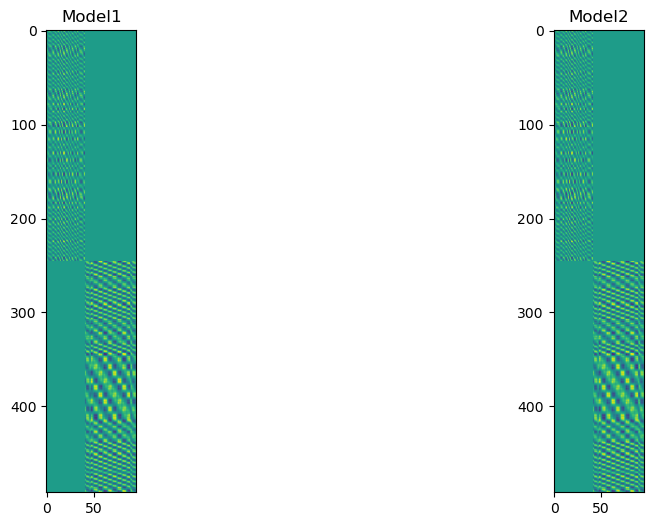

In [83]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(X)
plt.title('Model1')
plt.subplot(1, 2, 2)
plt.imshow(C_model)
plt.title('Model2')

In [84]:
Cx0 = X[:Cx0.shape[0], :Cx0.shape[1]]
Cyx0 = X[:Cx0.shape[0], Cx0.shape[1]:]
Cxy0 = X[Cx0.shape[0]:, :Cx0.shape[1]]
Cy0 = X[Cx0.shape[0]:, Cx0.shape[1]:]

Cx1 = C_model[:Cx0.shape[0], :Cx0.shape[1]]
Cyx1 = C_model[:Cx0.shape[0], Cx0.shape[1]:]
Cxy1 = C_model[Cx0.shape[0]:, :Cx0.shape[1]]
Cy1 = C_model[Cx0.shape[0]:, Cx0.shape[1]:]

In [93]:
Cx = np.array(ORM_230426_1)[:len(BPM_names), :len(HCM_names)]
Cyx = np.array(ORM_230426_1)[:len(BPM_names), len(HCM_names):]
Cxy = np.array(ORM_230426_1)[len(BPM_names):, :len(HCM_names)]
Cy = np.array(ORM_230426_1)[len(BPM_names):, len(HCM_names):]

Y = np.zeros((Cx.shape[0]+Cy.shape[0], Cx.shape[1]+Cy.shape[1]))
Y[:Cx.shape[0], :Cx.shape[1]] = (Cx*10)
Y[:Cx.shape[0], Cx.shape[1]:] = (Cyx*10)
Y[Cx.shape[0]:, :Cx.shape[1]] = (Cxy*10)
Y[Cx.shape[0]:, Cx.shape[1]:] = (Cy*10)

bpm_noisex = Noise_BPMx_230426_1/1000
min_value = np.min(abs(bpm_noisex))
bpm_noisex /= min_value
sigmax = bpm_noisex

bpm_noisey = Noise_BPMy_230426_1/1000
min_value = np.min(abs(bpm_noisey))
bpm_noisey /= min_value
sigmay = bpm_noisey
sigma = np.concatenate((sigmax, sigmay))
diagonal_values = 1 / np.square(sigma)
W = np.diag(diagonal_values)
print(W)

[[0.00356713 0.         0.         ... 0.         0.         0.        ]
 [0.         0.00852905 0.         ... 0.         0.         0.        ]
 [0.         0.         0.02389294 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.29328769 0.         0.        ]
 [0.         0.         0.         ... 0.         0.03028215 0.        ]
 [0.         0.         0.         ... 0.         0.         0.02460973]]


Text(0.5, 1.0, 'Model2')

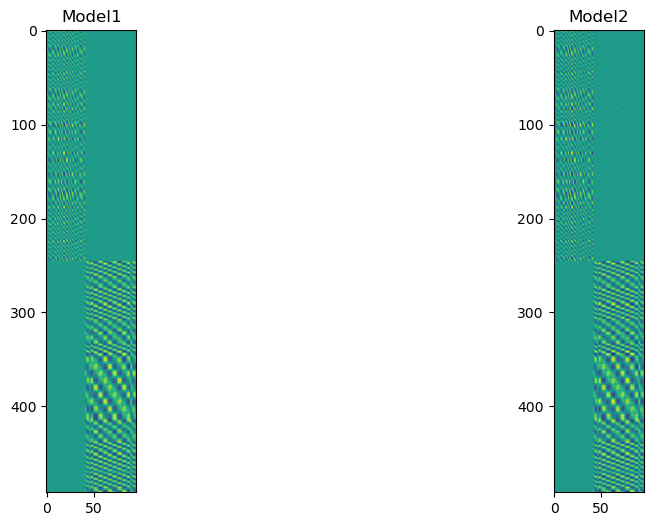

In [86]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(C_model)
plt.title('Model1')
plt.subplot(1, 2, 2)
plt.imshow(Y)
plt.title('Model2')

In [88]:
dCx = np.load('dCx_p3_hv.npy') # Jacobian calculated using HCM / VCM
dCy = np.load('dCy_p3_hv.npy')
dCxy =  np.load('dCxy_p3_hv.npy')
dCyx = np.load('dCyx_p3_hv.npy')

dCx =  np.transpose(dCx, (0, 2, 1))
dCy =  np.transpose(dCy, (0, 2, 1))
dCxy =  np.transpose(dCxy, (0, 2, 1))
dCyx =  np.transpose(dCyx, (0, 2, 1))

J1 = np.zeros((len(dCx), Cx0.shape[0] + Cy0.shape[0], Cx0.shape[1] + Cy0.shape[1]))

J1[:, :dCx.shape[1], :dCx.shape[2]] = dCx
J1[:, :dCx.shape[1], dCx.shape[2]:] = dCyx
J1[:, dCx.shape[1]:, :dCx.shape[2]] = dCxy
J1[:, dCx.shape[1]:, dCx.shape[2]:] = dCy

In [99]:
length_quads = len(quadOrds)
length_corrections = len(concatenate(Corords))
length_bpm = len(bpm_indices) * 2
j2 = np.zeros((length_corrections, C_model.shape[0],
                       C_model.shape[1]))
for i in range(length_corrections):
    j2[i] = C_model
j3 = np.zeros((length_bpm, C_model.shape[0], C_model.shape[1]))
for i in range(length_bpm):
    j3[i] = C_model
J = np.zeros((length_quads + length_corrections + length_bpm, C_model.shape[0], C_model.shape[1]))
J[:length_quads] = J1
J[length_quads:length_quads+length_corrections] = j2
J[length_quads+length_corrections:] = j3

In [105]:
import numpy as np
Nk = len(dCx)
for i in range(Nk):
    for j in range(Nk):
        J[i, j] = np.sum(np.dot(np.dot(W, J[i]), J[j].T))

In [103]:
shape(W)

(492, 492)

In [104]:
shape(J[6])

(492, 96)

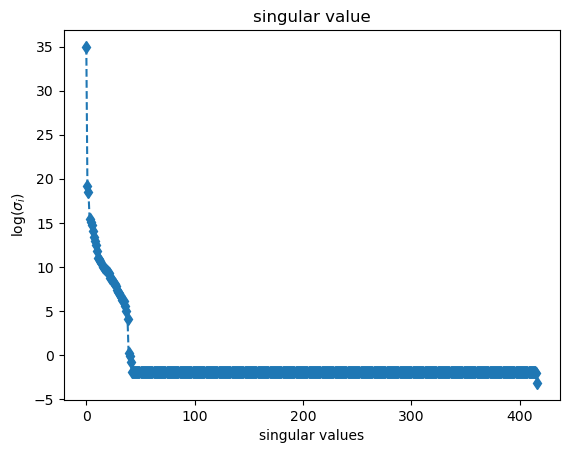

In [67]:
u, s, v = np.linalg.svd(J, full_matrices=True)
plt.plot(np.log(s), 'd--')
plt.title('singular value')
plt.xlabel('singular values')
plt.ylabel('$\log(\sigma_i)$')
plt.show()

In [53]:
smat = 0.0 * J
si = s ** -1
n_sv = 100
si[n_sv:] *= 0.0
Nk = len(J)
smat[:Nk, :Nk] = np.diag(si)
Jt = np.dot(v.transpose(), np.dot(smat.transpose(), u.transpose()))

In [54]:
bpm_noise = Noise_BPMx_230426_1/1000
min_value = np.min(abs(bpm_noise))
bpm_noise /= min_value
diagonal_values = 1 / np.square(bpm_noise)
W = np.diag(diagonal_values)
print(W)

[[0.00356713 0.         0.         ... 0.         0.         0.        ]
 [0.         0.00852905 0.         ... 0.         0.         0.        ]
 [0.         0.         0.02389294 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.003142   0.         0.        ]
 [0.         0.         0.         ... 0.         0.11531502 0.        ]
 [0.         0.         0.         ... 0.         0.         0.01137613]]


In [101]:
def loco_correction(objective_function, initial_guess0, orbit_response_matrix_model, orbit_response_matrix_measured, J, Jt, lengths, including_fit_parameters, method='lm', verbose=2, max_iterations=1000, eps=1e-6, W):
    from scipy.optimize import least_squares
    from sklearn.metrics import r2_score, mean_squared_error
    if method == 'lm':
        result = least_squares(objective_function, initial_guess0, method=method, verbose=verbose)
        params_to_check = calculate_parameters(result.x, orbit_response_matrix_model, orbit_response_matrix_measured, J, lengths,including_fit_parameters)
        return result, params_to_check
    else:
        if method == 'ng':
            Iter = 0
            while True:
                Iter += 1

                if max_iterations is not None and Iter > max_iterations:
                    break

                model = orbit_response_matrix_model
                if 'quads' in including_fit_parameters:
                    len_quads = lengths[0]
                    delta_g = initial_guess0[:len_quads]
                    B = np.sum([J[k] * delta_g[k] for k in range(len(delta_g))], axis=0)
                    model += B

                if 'cor' in including_fit_parameters:
                    len_corr = lengths[1]
                    delta_x = initial_guess0[len_quads:len_quads + len_corr]
                    Co = orbit_response_matrix_model * delta_x
                    model += Co

                if 'bpm' in including_fit_parameters:
                    len_bpm = lengths[2]
                    delta_y = initial_guess0[len_quads + len_corr:]
                    G = orbit_response_matrix_model * delta_y[:, np.newaxis]
                    model += G


                r = orbit_response_matrix_measured - model

                t2 = np.zeros([len(initial_guess0), 1])
                for i in range(len(initial_guess0)):
                    t2[i] = np.sum(np.dot(np.dot(J[i],W), r.T)) #############

                t3 = (np.dot(Jt, t2)).reshape(-1)
                initial_guess1 = initial_guess0 + t3
                t4 = abs(initial_guess1 - initial_guess0)

                if max(t4) <= eps:
                    break
                initial_guess0 = initial_guess1


        return initial_guess0


def objective(delta_params, orbit_response_matrix_model, orbit_response_matrix_measured, J, lengths, including_fit_parameters, W):

    D = orbit_response_matrix_measured - orbit_response_matrix_model
    residuals = D
    if 'quads' in including_fit_parameters:
        len_quads = lengths[0]
        delta_g = delta_params[:len_quads]
        B = np.sum([J[k] * delta_g[k] for k in range(len(delta_g))], axis=0)
        residuals -= B

    if 'cor' in including_fit_parameters:
        len_corr = lengths[1]
        delta_x = delta_params[len_quads:len_quads + len_corr]
        Co = orbit_response_matrix_model * delta_x
        residuals -= Co

    if 'bpm' in including_fit_parameters:
        len_bpm = lengths[2]
        delta_y = delta_params[len_quads + len_corr:]
        G = orbit_response_matrix_model * delta_y[:, np.newaxis]
        residuals -= G

    residuals = residuals

    return residuals.ravel()



def calculate_parameters(parameters, orbit_response_matrix_model, orbit_response_matrix_measured, J, lengths, including_fit_parameters):
    model = orbit_response_matrix_model
    len_quads = lengths[0]
    #len_corr = lengths[1]
    #len_bpm = lengths[2]

    if 'quads' in including_fit_parameters:
        delta_g = parameters[:len_quads]
        B = np.sum([J[k] * delta_g[k] for k in range(len(delta_g))], axis=0)
        model += B

    if 'cor' in including_fit_parameters:
        len_corr = lengths[1]
        delta_x = delta_params[len_quads:len_quads + len_corr]
        Co = orbit_response_matrix_model * delta_x
        model += Co

    if 'bpm' in including_fit_parameters:
        len_bpm = lengths[2]
        delta_y = delta_params[len_quads + len_corr:]
        G = orbit_response_matrix_model * delta_y[:, np.newaxis]
        model += G



    residuals = orbit_response_matrix_measured- model
    # Calculate R-squared
    r_squared = r2_score(orbit_response_matrix_measured, model)

    # Calculate RMSE
    rms = sqrt(mean_squared_error(orbit_response_matrix_measured,model))

    params_to_check_ = {

        'r_squared': r_squared,
        'rmse': rms,
    }

    return params_to_check_

In [107]:
quadsOrds = quads_indices
initial_guess = np.zeros(len((quadsOrds)) + len(np.concatenate(Corords)) +  len(bpm_indices) *2)
initial_guess[0:len((quadsOrds))] = 1e-6
initial_guess[len((quadsOrds)):len((quadsOrds)) + len(np.concatenate(Corords))] = 1e-6
initial_guess[len((quadsOrds)) + len(np.concatenate(Corords)):] = 1e-6
lengths = [len((quadsOrds)),len(np.concatenate(Corords)),  len(bpm_indices) *2]
including_fit_parameters = ['quads', 'cor', 'bpm']

In [ ]:
tmp = np.sum(J, axis=1)
t1 = tmp @ tmp.T
u, s, v = np.linalg.svd(t1, full_matrices=True)
plt.plot(np.log(s), 'd--')
plt.title('singular value')
plt.xlabel('singular values')
plt.ylabel('$\log(\sigma_i)$')
plt.show()

In [112]:
start_time = time.time()
fit_parameters, params_to_check  = loco_correction(lambda delta_params: objective(delta_params, X, Y, J, lengths, including_fit_parameters, W),initial_guess,X, Y, J,Jt, lengths,including_fit_parameters
                         , verbose=2, max_iterations= 100, eps=1e-6, method='ng',W= W)


end_time = time.time()

elapsed_time = end_time - start_time
print(f"Time taken by lm: {elapsed_time} seconds")

`xtol` termination condition is satisfied.
Function evaluations 19137, initial cost 2.4083e+07, final cost 7.0938e+01, first-order optimality 4.58e+02.


NameError: name 'delta_params' is not defined

In [ ]:
def setCorrection(ring, r ,quadInd):
    for i in range(len(quadInd)):
        qInd = quadInd[i]
        ring[qInd].K -= -r[i]

setCorrection(ring, r , quads_indices)
_, _, twiss_cor = at.get_optics(ring, bpm_indices)

In [ ]:
Beta_x = twiss.beta[:, 0]
Beta_y = twiss.beta[:, 1]
print('Beta beating after corrections')
bx_rms_cor, by_rms_cor = getBetaBeat(ring, twiss, bpm_indices, makeplot = True)
_, _, twiss = at.get_optics(ring, bpm_indices)
s_pos = twiss.s_pos
Beta_x = twiss.beta[:, 0]
Beta_y = twiss.beta[:, 1]

plt.rc('font', size=13)
fig, ax = plt.subplots()
ax.plot(s_pos, Beta_x)
ax.set_xlabel("s_pos [m]", fontsize=14)
ax.set_ylabel(r'$\beta_x%$', fontsize=14)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
ax.grid(True, which='both', linestyle=':', color='gray')
plt.title('Horizontal beta')
plt.show()
fig, ax = plt.subplots()
ax.plot(s_pos, Beta_y)
ax.set_xlabel("s_pos [m]", fontsize=14)
ax.set_ylabel(r'$\beta_y%$', fontsize=14)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
ax.grid(True, which='both', linestyle=':', color='gray')
plt.title('Vertical beta')
plt.show()